### Library Import

In [65]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb
from xgboost import XGBClassifier

# from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns


### Data Load

In [66]:
# drive.mount('/content/drive')

# 기본 경로 설정
base_path = "/data/ephemeral/home/JihoonRyu00/data/"

In [84]:
# LightGBM과 XGBoost 피처 중요도 CSV 파일 로드
lgb_importances = pd.read_csv(os.path.join(base_path, 'top_50_important_features_data_LGBM.csv'))
xgb_importances = pd.read_csv(os.path.join(base_path, 'top_50_important_features_data_XGB.csv'))






# 상위 20개 column 선택
lgb_top_20 = lgb_importances.iloc[:, :20]
xgb_top_20 = xgb_importances.iloc[:, :20]

# 두 데이터프레임을 합침 (중복된 열 포함)
merged_df = pd.concat([lgb_top_20, xgb_top_20], axis=1)

# 중복된 열(동일한 feature 이름을 가진 열) 제거
merged_df_unique = merged_df.loc[:, ~merged_df.columns.duplicated()]

# 마지막에 '_type', 'target', 'ID' 열 추가 (원본 CSV 파일에서 가져옴)
common_columns = ['_type', 'target', 'ID']

# 원본에서 해당 열들을 가져와 합치기
final_df = pd.concat([merged_df_unique, lgb_importances[common_columns]], axis=1)

# 결과 확인
print(f"최종 데이터프레임 크기: {final_df.shape}")
print(final_df)
final_df.to_csv(os.path.join(base_path, 'top_20_important_features_data_LGBM+XGB.csv'), index=False)




# # 두 데이터프레임을 합침
# merged_df = pd.concat([lgb_importances, xgb_importances], axis=1)

# # 중복된 열(동일한 피처 이름을 가진 열) 찾기
# duplicate_columns = merged_df.columns[merged_df.columns.duplicated()]

# # 중복된 열 제거
# merged_df_unique = merged_df.loc[:, ~merged_df.columns.duplicated()]

# # 결과 확인
# print(f"중복된 열: {duplicate_columns}")
# print(f"중복된 열을 제거한 데이터프레임 크기: {merged_df_unique.shape}")

최종 데이터프레임 크기: (11552, 43)
       hourly_network-data_block-bytes_block_bytes_shift_24h_rolling_std_2h  \
0                                            -999.000000                      
1                                            -999.000000                      
2                                            -999.000000                      
3                                            -999.000000                      
4                                            -999.000000                      
...                                                  ...                      
11547                                       15558.352655                      
11548                                       15558.352655                      
11549                                       15558.352655                      
11550                                       15558.352655                      
11551                                       15558.352655                      

       hourly_market-data

In [68]:
# merged_df_unique.to_csv(os.path.join(base_path, 'top_50_important_features_data_LGBM+XGB.csv'), index=False)

In [85]:
df=final_df

In [86]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

test_df

,hourly_network-data_block-bytes_block_bytes_shift_24h_rolling_std_2h,hourly_market-data_open-interest_binance_all_symbol_open_interest_shift_6h_rolling_std_2h,hourly_market-data_open-interest_binance_btc_usd_open_interest_shift_3h_rolling_std_2h,hourly_market-data_taker-buy-sell-stats_bitmex_taker_sell_volume_rolling_mean_1h,hourly_network-data_tokens-transferred_tokens_transferred_total_shift_4h_rolling_mean_1h,hourly_market-data_open-interest_htx_global_all_symbol_open_interest_shift_24h_rolling_mean_168h,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio_rolling_mean_1h,hourly_network-data_addresses-count_addresses_count_active_shift_3h_rolling_std_3h,hourly_market-data_open-interest_bitmex_btc_usd_open_interest_shift_3h_rolling_std_2h,hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio_rolling_mean_1h,...,hourly_market-data_open-interest_htx_global_all_symbol_open_interest_shift_4h_rolling_mean_2h,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_rolling_mean_7h,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_rolling_mean_3h,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_rolling_mean_2h,hourly_market-data_taker-buy-sell-stats_okx_taker_volume_diff_rolling_mean_8h,hourly_market-data_open-interest_htx_global_all_symbol_open_interest_shift_2h_rolling_mean_168h,hourly_market-data_liquidations_bybit_btc_usdt_short_liquidations_usd_shift_3h_rolling_mean_4h,hourly_market-data_liquidations_bybit_btc_usdt_liquidation_diff_rolling_sum_168h,target,ID
8760,814.233459,8.100767e+06,7.327748e+05,3957200.0,20015.782598,1.345933e+08,0.562104,23721.202380,3.391991e+05,0.445307,...,1.341086e+08,4.709309e+06,83481.564733,11879850.0,-64475.0,1.349516e+08,322.251550,-210.825546,NaN,2024-01-01 00:00:00
8761,23044.884985,7.187470e+06,1.904521e+06,4293300.0,13822.498528,1.346106e+08,0.531150,5058.148970,6.395781e+05,0.471001,...,1.338677e+08,5.624427e+06,3541.753733,14035600.0,-368500.0,1.349481e+08,0.000000,-212.372091,NaN,2024-01-01 01:00:00
8762,1305.476253,3.688401e+06,3.649095e+06,1886200.0,18699.215727,1.346208e+08,0.470910,5193.472281,5.967981e+04,0.541286,...,1.329130e+08,5.508847e+06,62248.320133,12653200.0,-974562.5,1.349482e+08,0.000000,-212.233091,NaN,2024-01-01 02:00:00
8763,26210.091356,1.083196e+07,1.258155e+06,5714700.0,8369.792889,1.346291e+08,0.423491,7765.540612,3.536241e+05,0.569910,...,1.324858e+08,5.620660e+06,67472.215467,10301000.0,-2037837.5,1.349569e+08,11414.619325,-208.940091,NaN,2024-01-01 03:00:00
8764,18515.995126,4.451063e+07,2.361525e+06,4271000.0,40439.047544,1.346420e+08,0.518226,28419.972983,2.404870e+05,0.500867,...,1.330288e+08,5.283996e+06,108405.029567,11365750.0,-2205125.0,1.349637e+08,26184.091425,-205.071091,NaN,2024-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,15558.352655,1.994770e+07,3.159707e+06,12140100.0,0.000000,1.462065e+08,0.556337,28941.665127,4.581345e+05,0.539857,...,1.391019e+08,8.193670e+06,50116.910533,10726550.0,693637.5,1.462065e+08,18751.710175,-418.896016,NaN,2024-04-26 03:00:00
11548,15558.352655,1.994770e+07,4.080006e+06,12140100.0,58138.258771,1.462065e+08,0.556337,30030.961262,2.814568e+06,0.526107,...,1.391019e+08,8.193670e+06,50116.910533,11369850.0,195100.0,1.462065e+08,96932.674400,-394.289164,NaN,2024-04-26 04:00:00
11549,15558.352655,1.994770e+07,5.745879e+06,12140100.0,15217.144002,1.462065e+08,0.556337,7596.566922,4.461844e+04,0.443380,...,1.391019e+08,8.193670e+06,50116.910533,13651300.0,310400.0,1.462065e+08,96932.674400,-398.056085,NaN,2024-04-26 05:00:00
11550,15558.352655,1.994770e+07,4.046065e+05,12140100.0,17753.353670,1.462065e+08,0.556337,10749.783362,3.196123e+05,0.579181,...,1.391019e+08,8.193670e+06,50116.910533,13498200.0,-86875.0,1.462065e+08,96932.674400,-355.271524,NaN,2024-04-26 06:00:00


In [87]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# train_test_split으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis=1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.05, 
    num_leaves=31, 
    n_estimators=500, 
    objective='multiclass', 
    num_class=4
)

# XGBoost 모델 정의
xgb_model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=5,
    objective='multi:softprob',  # 다중 클래스 분류
    num_class=4,
    eval_metric='mlogloss'
)

# 앙상블 모델 정의 (soft voting)
ensemble_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model)], 
    voting='soft'  # soft는 각 모델의 예측 확률을 기반으로, hard는 다수결
)

# 앙상블 모델 학습  
ensemble_model.fit(x_train, y_train)

# 검증 데이터에 대한 예측
y_valid_pred = ensemble_model.predict(x_valid)

# 성능 평가 (정확도)
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'앙상블 모델 정확도: {accuracy:.4f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 40
[LightGBM] [Info] Start training from score -2.472992
[LightGBM] [Info] Start training from score -0.894135
[LightGBM] [Info] Start training from score -0.873416
[LightGBM] [Info] Start training from score -2.417056
앙상블 모델 정확도: 0.4429


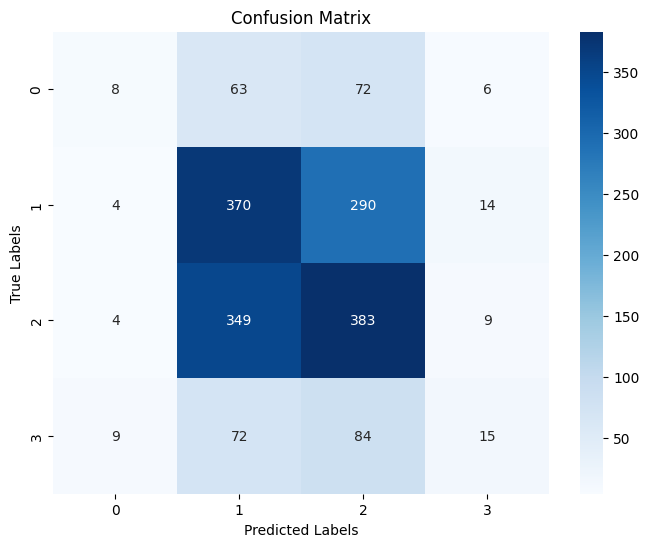

In [88]:
# 혼동행렬 계산
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_valid), yticklabels=np.unique(y_valid))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [89]:
submission_df: pd.DataFrame = pd.read_csv(os.path.join(base_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
submission_df

,ID
0,2024-01-01 00:00:00
1,2024-01-01 01:00:00
2,2024-01-01 02:00:00
3,2024-01-01 03:00:00
4,2024-01-01 04:00:00
...,...
2787,2024-04-26 03:00:00
2788,2024-04-26 04:00:00
2789,2024-04-26 05:00:00
2790,2024-04-26 06:00:00


In [93]:
# 전체 train 데이터로 학습 (검증 데이터 나누지 않음)
X_train = train_df.drop(columns=["target", "ID"])
y_train = train_df["target"].astype(int)

# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier(
    learning_rate=0.05, 
    num_leaves=31, 
    n_estimators=500, 
    objective='multiclass', 
    num_class=4
)

# XGBoost 모델 정의
xgb_model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=5,
    objective='multi:softprob',  # 다중 클래스 분류
    num_class=4,
    eval_metric='mlogloss'
)

# 앙상블 모델 정의 (soft voting)
ensemble_model = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model)], 
    voting='soft'  # soft는 각 모델의 예측 확률을 기반으로, hard는 다수결
)

# 앙상블 모델 학습  
ensemble_model.fit(X_train, y_train)

# predict
y_test_pred = ensemble_model.predict(test_df.drop(columns=["target","ID"]))
# y_test_pred_class = np.argmax(y_test_pred, axis = 1)

# output file 할당 후 save
submission_df = submission_df.assign(target=y_test_pred)
submission_df.to_csv("output.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 40
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.904940
[LightGBM] [Info] Start training from score -0.869732
[LightGBM] [Info] Start training from score -2.387109


AxisError: axis 1 is out of bounds for array of dimension 1

In [92]:
test_df.drop(["target", "ID"])

KeyError: "['target', 'ID'] not found in axis"